<a href="https://colab.research.google.com/github/Enishe1/WildVision/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install pyinaturalist


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 5.9 MB/s eta 0:00:00


In [11]:
from pyinaturalist import get_observations
import pandas as pd
import time
from requests.exceptions import RequestException

# 100 species from Bosnia and Herzegovina
TARGET_SPECIES = [
    # Mammals (25)
    "Lynx lynx", "Ursus arctos", "Canis lupus", "Capreolus capreolus", "Sus scrofa",
    "Martes martes", "Vulpes vulpes", "Lutra lutra", "Rupicapra rupicapra", "Myotis myotis",
    "Sciurus vulgaris", "Lepus europaeus", "Felis silvestris", "Meles meles", "Neomys fodiens",
    "Cervus elaphus", "Dama dama", "Mustela nivalis", "Glis glis", "Talpa europaea",
    "Miniopterus schreibersii", "Rhinolophus ferrumequinum", "Nyctalus noctula", "Erinaceus europaeus", "Microtus arvalis",

    # Birds (35)
    "Aquila chrysaetos", "Falco peregrinus", "Bubo bubo", "Ciconia ciconia", "Picus viridis",
    "Lanius collurio", "Sitta europaea", "Turdus merula", "Emberiza citrinella", "Alcedo atthis",
    "Milvus migrans", "Corvus corax", "Parus major", "Motacilla alba", "Hirundo rustica",
    "Phylloscopus collybita", "Luscinia megarhynchos", "Accipiter nisus", "Strix aluco", "Apus apus",
    "Columba palumbus", "Anas platyrhynchos", "Ardea cinerea", "Upupa epops", "Pyrrhocorax pyrrhocorax",
    "Falco tinnunculus", "Sylvia atricapilla", "Regulus regulus", "Carduelis carduelis", "Streptopelia decaocto",
    "Certhia brachydactyla", "Jynx torquilla", "Dryocopus martius", "Turdus philomelos", "Passer domesticus",

    # Reptiles & Amphibians (15)
    "Vipera berus", "Zamenis longissimus", "Natrix natrix", "Lacerta viridis", "Podarcis muralis",
    "Triturus carnifex", "Bombina variegata", "Rana temporaria", "Salamandra salamandra", "Bufo bufo",
    "Anguis fragilis", "Emys orbicularis", "Hyla arborea", "Pelophylax kl. esculentus", "Coronella austriaca",

    # Fish (10)
    "Salmo trutta", "Hucho hucho", "Barbus balcanicus", "Squalius cephalus", "Alburnus alburnus",
    "Esox lucius", "Silurus glanis", "Thymallus thymallus", "Cottus gobio", "Phoxinus phoxinus",

    # Insects (15)
    "Lucanus cervus", "Papilio machaon", "Apis mellifera", "Calopteryx splendens", "Carabus intricatus",
    "Rosalia alpina", "Morimus funereus", "Lycaena dispar", "Vespa crabro", "Polyommatus icarus",
    "Odonata", "Cetonia aurata", "Bombus terrestris", "Limenitis reducta", "Mantis religiosa"
]

def fetch_species_observations(species_list, max_retries=3):
    """Fetch observations for each species in the list with retry logic"""
    all_observations = []

    for species in species_list:
        retries = 0
        while retries < max_retries:
            try:
                print(f"Fetching data for {species}... (Attempt {retries + 1})")
                response = get_observations(
                    taxon_name=species,
                    quality_grade="research",
                    per_page=100,
                    geo=True
                )

                if response and 'results' in response and response['results']:
                    df = pd.DataFrame(response['results'])
                    df['target_species'] = species
                    all_observations.append(df)
                    print(f"Found {len(response['results'])} observations for {species}")
                    break
                else:
                    print(f"No observations found for {species}")
                    break

            except RequestException as e:
                print(f"Error fetching {species}: {str(e)}")
                retries += 1
                if retries < max_retries:
                    time.sleep(5)
                else:
                    print(f"Max retries reached for {species}")
                    break

        time.sleep(1)

    return pd.concat(all_observations, ignore_index=True) if all_observations else None


print(f"Starting to fetch data for {len(TARGET_SPECIES)} species...")
observations_df = fetch_species_observations(TARGET_SPECIES)

if observations_df is not None:

    observations_df['observed_on'] = pd.to_datetime(
        observations_df['observed_on'],
        utc=True
    ).dt.tz_convert(None)


    observations_df['photo_url'] = observations_df['photos'].apply(
        lambda x: x[0]['url'].replace('square', 'medium') if x and isinstance(x, list) and len(x) > 0 else None
    )


    timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M')
    filename = f'bosnia_wildlife_observations_{timestamp}.csv'
    observations_df.to_csv(filename, index=False)

    print(f"\nSuccess! Saved {len(observations_df)} observations to {filename}")
    print(f"Species coverage: {observations_df['target_species'].nunique()}/100 species found")


    print("\nTop 10 species by observation count:")
    print(observations_df['target_species'].value_counts().head(10))
else:
    print("No observations found for any species.")

Starting to fetch data for 100 species...
Fetching data for Lynx lynx... (Attempt 1)
Found 100 observations for Lynx lynx
Fetching data for Ursus arctos... (Attempt 1)
Found 100 observations for Ursus arctos
Fetching data for Canis lupus... (Attempt 1)
Found 100 observations for Canis lupus
Fetching data for Capreolus capreolus... (Attempt 1)
Found 100 observations for Capreolus capreolus
Fetching data for Sus scrofa... (Attempt 1)
Found 100 observations for Sus scrofa
Fetching data for Martes martes... (Attempt 1)
Found 100 observations for Martes martes
Fetching data for Vulpes vulpes... (Attempt 1)
Found 100 observations for Vulpes vulpes
Fetching data for Lutra lutra... (Attempt 1)
Found 100 observations for Lutra lutra
Fetching data for Rupicapra rupicapra... (Attempt 1)
Found 100 observations for Rupicapra rupicapra
Fetching data for Myotis myotis... (Attempt 1)
Found 100 observations for Myotis myotis
Fetching data for Sciurus vulgaris... (Attempt 1)
Found 100 observations for S

Fetching data for Turdus philomelos... (Attempt 1)
Found 100 observations for Turdus philomelos
Fetching data for Passer domesticus... (Attempt 1)
Found 100 observations for Passer domesticus
Fetching data for Vipera berus... (Attempt 1)
Found 100 observations for Vipera berus
Fetching data for Zamenis longissimus... (Attempt 1)
Found 100 observations for Zamenis longissimus
Fetching data for Natrix natrix... (Attempt 1)
Found 100 observations for Natrix natrix
Fetching data for Lacerta viridis... (Attempt 1)
Found 100 observations for Lacerta viridis
Fetching data for Podarcis muralis... (Attempt 1)
Found 100 observations for Podarcis muralis
Fetching data for Triturus carnifex... (Attempt 1)
Found 100 observations for Triturus carnifex
Fetching data for Bombina variegata... (Attempt 1)
Found 100 observations for Bombina variegata
Fetching data for Rana temporaria... (Attempt 1)
Found 100 observations for Rana temporaria
Fetching data for Salamandra salamandra... (Attempt 1)
Found 100

<ipython-input-11-48c8d29a9369>:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(all_observations, ignore_index=True) if all_observations else None



Success! Saved 9833 observations to bosnia_wildlife_observations_20250430_2302.csv
Species coverage: 100/100 species found

Top 10 species by observation count:
target_species
Lynx lynx              100
Ursus arctos           100
Canis lupus            100
Capreolus capreolus    100
Sus scrofa             100
Martes martes          100
Vulpes vulpes          100
Lutra lutra            100
Rupicapra rupicapra    100
Myotis myotis          100
Name: count, dtype: int64


Fetching first available photos for each species...


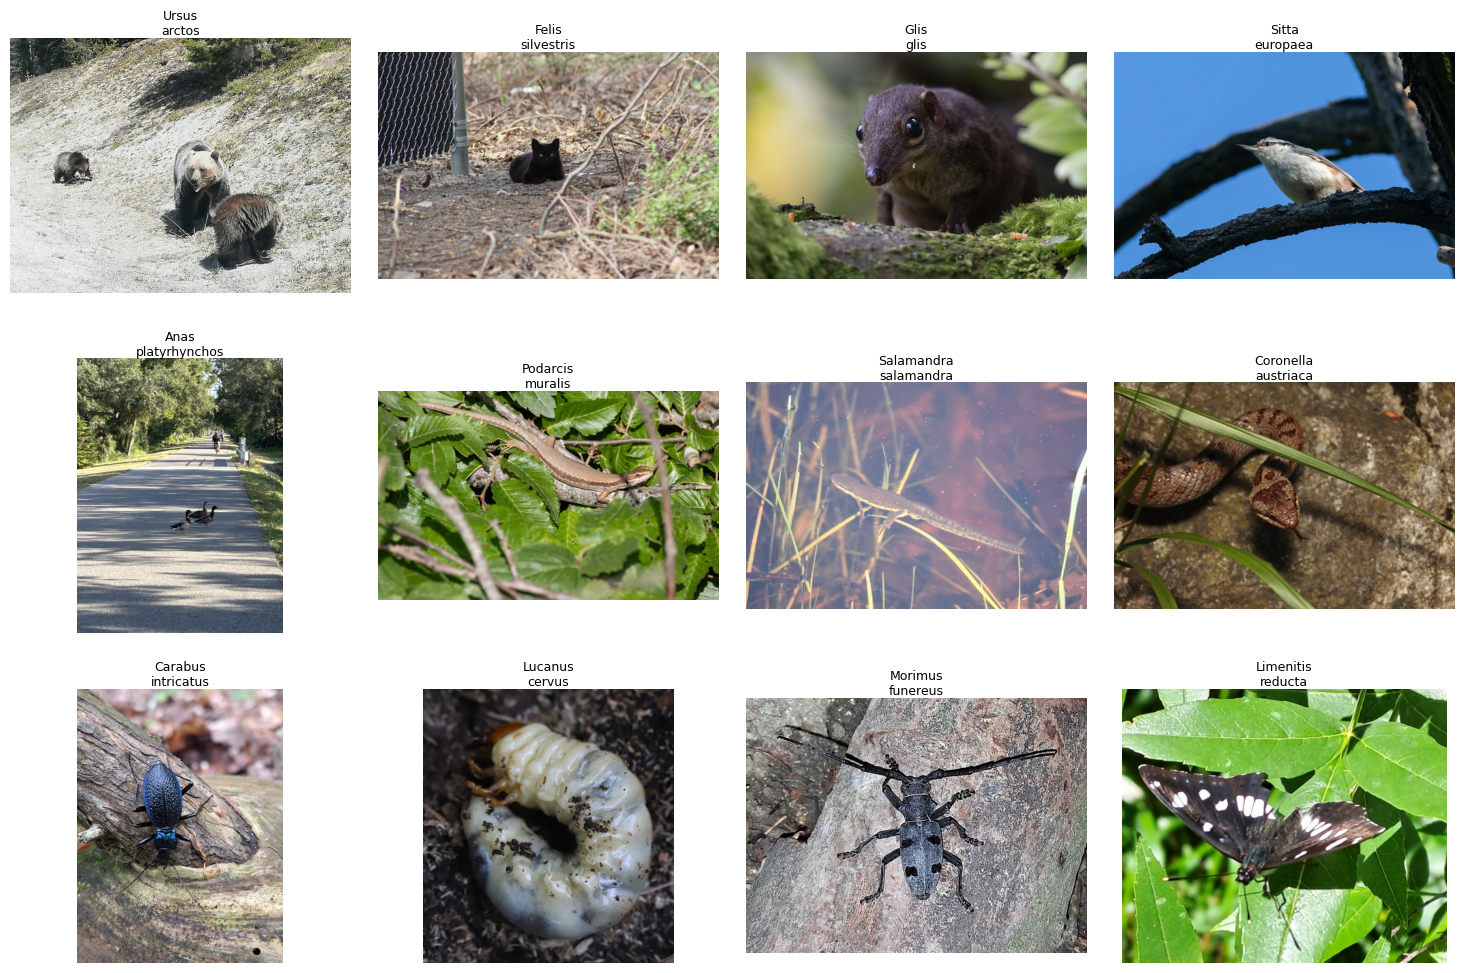

In [23]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from pyinaturalist import get_observations

TARGET_SPECIES = [
    "Ursus arctos",         # Brown Bear
    "Felis silvestris",     # Wildcat
    "Glis glis",            # Edible Dormouse
    "Sitta europaea",       # Eurasian Nuthatch
    "Anas platyrhynchos",   # Mallard
    "Podarcis muralis",     # Wall Lizard
    "Salamandra salamandra", # Fire Salamander
    "Coronella austriaca",  # Smooth Snake
    "Carabus intricatus",   # Blue Ground Beetle
    "Lucanus cervus",       # Stag Beetle
    "Morimus funereus",     # Longhorn Beetle
    "Limenitis reducta"     # Southern White Admiral
]

def get_first_photo(species_name):
    """Get the first available photo URL for a species"""
    try:
        response = get_observations(
            taxon_name=species_name,
            quality_grade="research",
            per_page=1,
            has_photos=True,
            geo=True
        )

        if response and 'results' in response and response['results']:
            photos = response['results'][0].get('photos', [])
            if photos:
                return photos[0]['url'].replace('square', 'medium')
        return None
    except Exception as e:
        print(f"Error fetching {species_name}: {str(e)}")
        return None

def display_species_photos(species_list):
    """Display first photo for each species"""
    plt.figure(figsize=(15, 10))
    n_cols = 4
    n_rows = int(np.ceil(len(species_list) / n_cols))

    for i, species in enumerate(species_list):
        plt.subplot(n_rows, n_cols, i+1)
        photo_url = get_first_photo(species)

        if photo_url:
            try:
                response = requests.get(photo_url, timeout=10)
                img = Image.open(BytesIO(response.content))
                plt.imshow(img)
            except Exception as e:
                print(f"Error loading image for {species}: {str(e)}")
                display_missing_photo(species)
        else:
            display_missing_photo(species)

        plt.title(format_species_name(species), fontsize=9, pad=2)
        plt.axis('off')

    plt.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)
    plt.show()

def display_missing_photo(species):
    """Display placeholder when photo is missing"""
    plt.text(0.5, 0.5, "No photo\navailable",
             ha='center', va='center', fontsize=8)
    plt.text(0.5, 0.2, format_species_name(species),
             ha='center', va='center', fontsize=8)

def format_species_name(scientific_name):
    """Format scientific name properly"""
    parts = scientific_name.split()
    if len(parts) == 2:
        return f"{parts[0]}\n{parts[1]}"
    return scientific_name

print("Fetching first available photos for each species...")
display_species_photos(TARGET_SPECIES)